In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2
from sklearn.ensemble          import IsolationForest

from sklearn.model_selection   import train_test_split
from sklearn.grid_search       import GridSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, mean_absolute_error, median_absolute_error

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import _pickle           as cPickle

import itertools
import argparse

from commonModel import loadData, FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS, TARGET_COLUMN

modelFileName = "model.pkl"
dataFileName  = "input/NizhnyNovgorod.csv"

Model = None
with open( modelFileName, 'rb') as fid:
        Model = cPickle.load(fid)
allDataFrame = loadData( dataFileName, COLUMN_TYPE='ALL' )

allDataFrame.head(10)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Tokenization took: 26.66 ms
Type conversion took: 48.81 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 12.98 ms
Type conversion took: 47.73 ms
Parser memory cleanup took: 0.01 ms
Shape of the data with all features: (109400, 11)
Shape of the data with numerical features: (109400, 11)
List of features contained our dataset: ['type', 'price', 'longitude', 'latitude', 'total_square', 'living_square', 'kitchen_square', 'number_of_rooms', 'floor_number', 'number_of_floors', 'building_type']
Shape of the data with numerical features: (63533, 11)
RobustScaler  [58673.91304348] [38027.11260926]
Shape of the data with numerical features: (26575, 11)


,type,price,longitude,latitude,total_square,living_square,kitchen_square,number_of_rooms,floor_number,number_of_floors,building_type
1,Вторичка,8200000.0,43.942485,56.301539,98.5,52.0,14.0,3,3,17,
2,Вторичка,2600000.0,43.923782,56.310448,64.0,42.0,6.0,4,2,5,
3,Вторичка,2750000.0,44.064952,56.291499,50.0,30.0,9.0,2,3,5,
4,Вторичка,2650000.0,43.957127,56.329128,45.0,31.0,6.0,2,2,5,Кирпичный
5,Вторичка,2400000.0,44.023674,56.316345,76.0,44.0,12.0,2,6,9,
6,Вторичка,3700000.0,43.996545,56.317807,45.0,37.0,6.5,2,2,8,Кирпичный
11,Вторичка,2800000.0,44.001350,56.310740,91.0,57.0,12.0,3,8,12,
12,Вторичка,4760000.0,43.943589,56.295000,105.0,64.0,10.0,4,8,9,Кирпичный
14,Вторичка,6600000.0,43.951441,56.340026,94.0,50.0,16.0,3,3,17,
17,Вторичка,2750000.0,43.868886,56.223651,57.6,39.9,7.0,3,3,9,


In [2]:
from commonModel import FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS

import warnings
warnings.filterwarnings('ignore')

NUMERICAL_COLUMNS = FLOAT_COLUMNS + INT_COLUMNS
testDataFrame = allDataFrame[NUMERICAL_COLUMNS]

FEATURES = list( testDataFrame.columns ); FEATURES.remove( TARGET_COLUMN )
COLUMNS  = list( testDataFrame.columns ); LABEL = TARGET_COLUMN;

index       = testDataFrame.index;
Y_dataFrame = testDataFrame    [[ TARGET_COLUMN ]];       Y_values = Y_dataFrame.values;
X_dataFrame = testDataFrame.drop( TARGET_COLUMN, axis=1); X_values = X_dataFrame.values;
Y_values    = Y_values.ravel()

Y_predict = Model.predict( X_values )

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_values, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_values, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_values, Y_predict ) )



Errors on the test set
mean square:      686721221146.2277
mean absolute:    242990.81285066818
median_absolute:  75191.66666666651


threshold =   2.5, good =      13955, bad =      12620, err = 0.4748824082784572
threshold =   5.0, good =      19460, bad =       7115, err = 0.26773283160865474
threshold =  10.0, good =      23296, bad =       3279, err = 0.12338664158043273


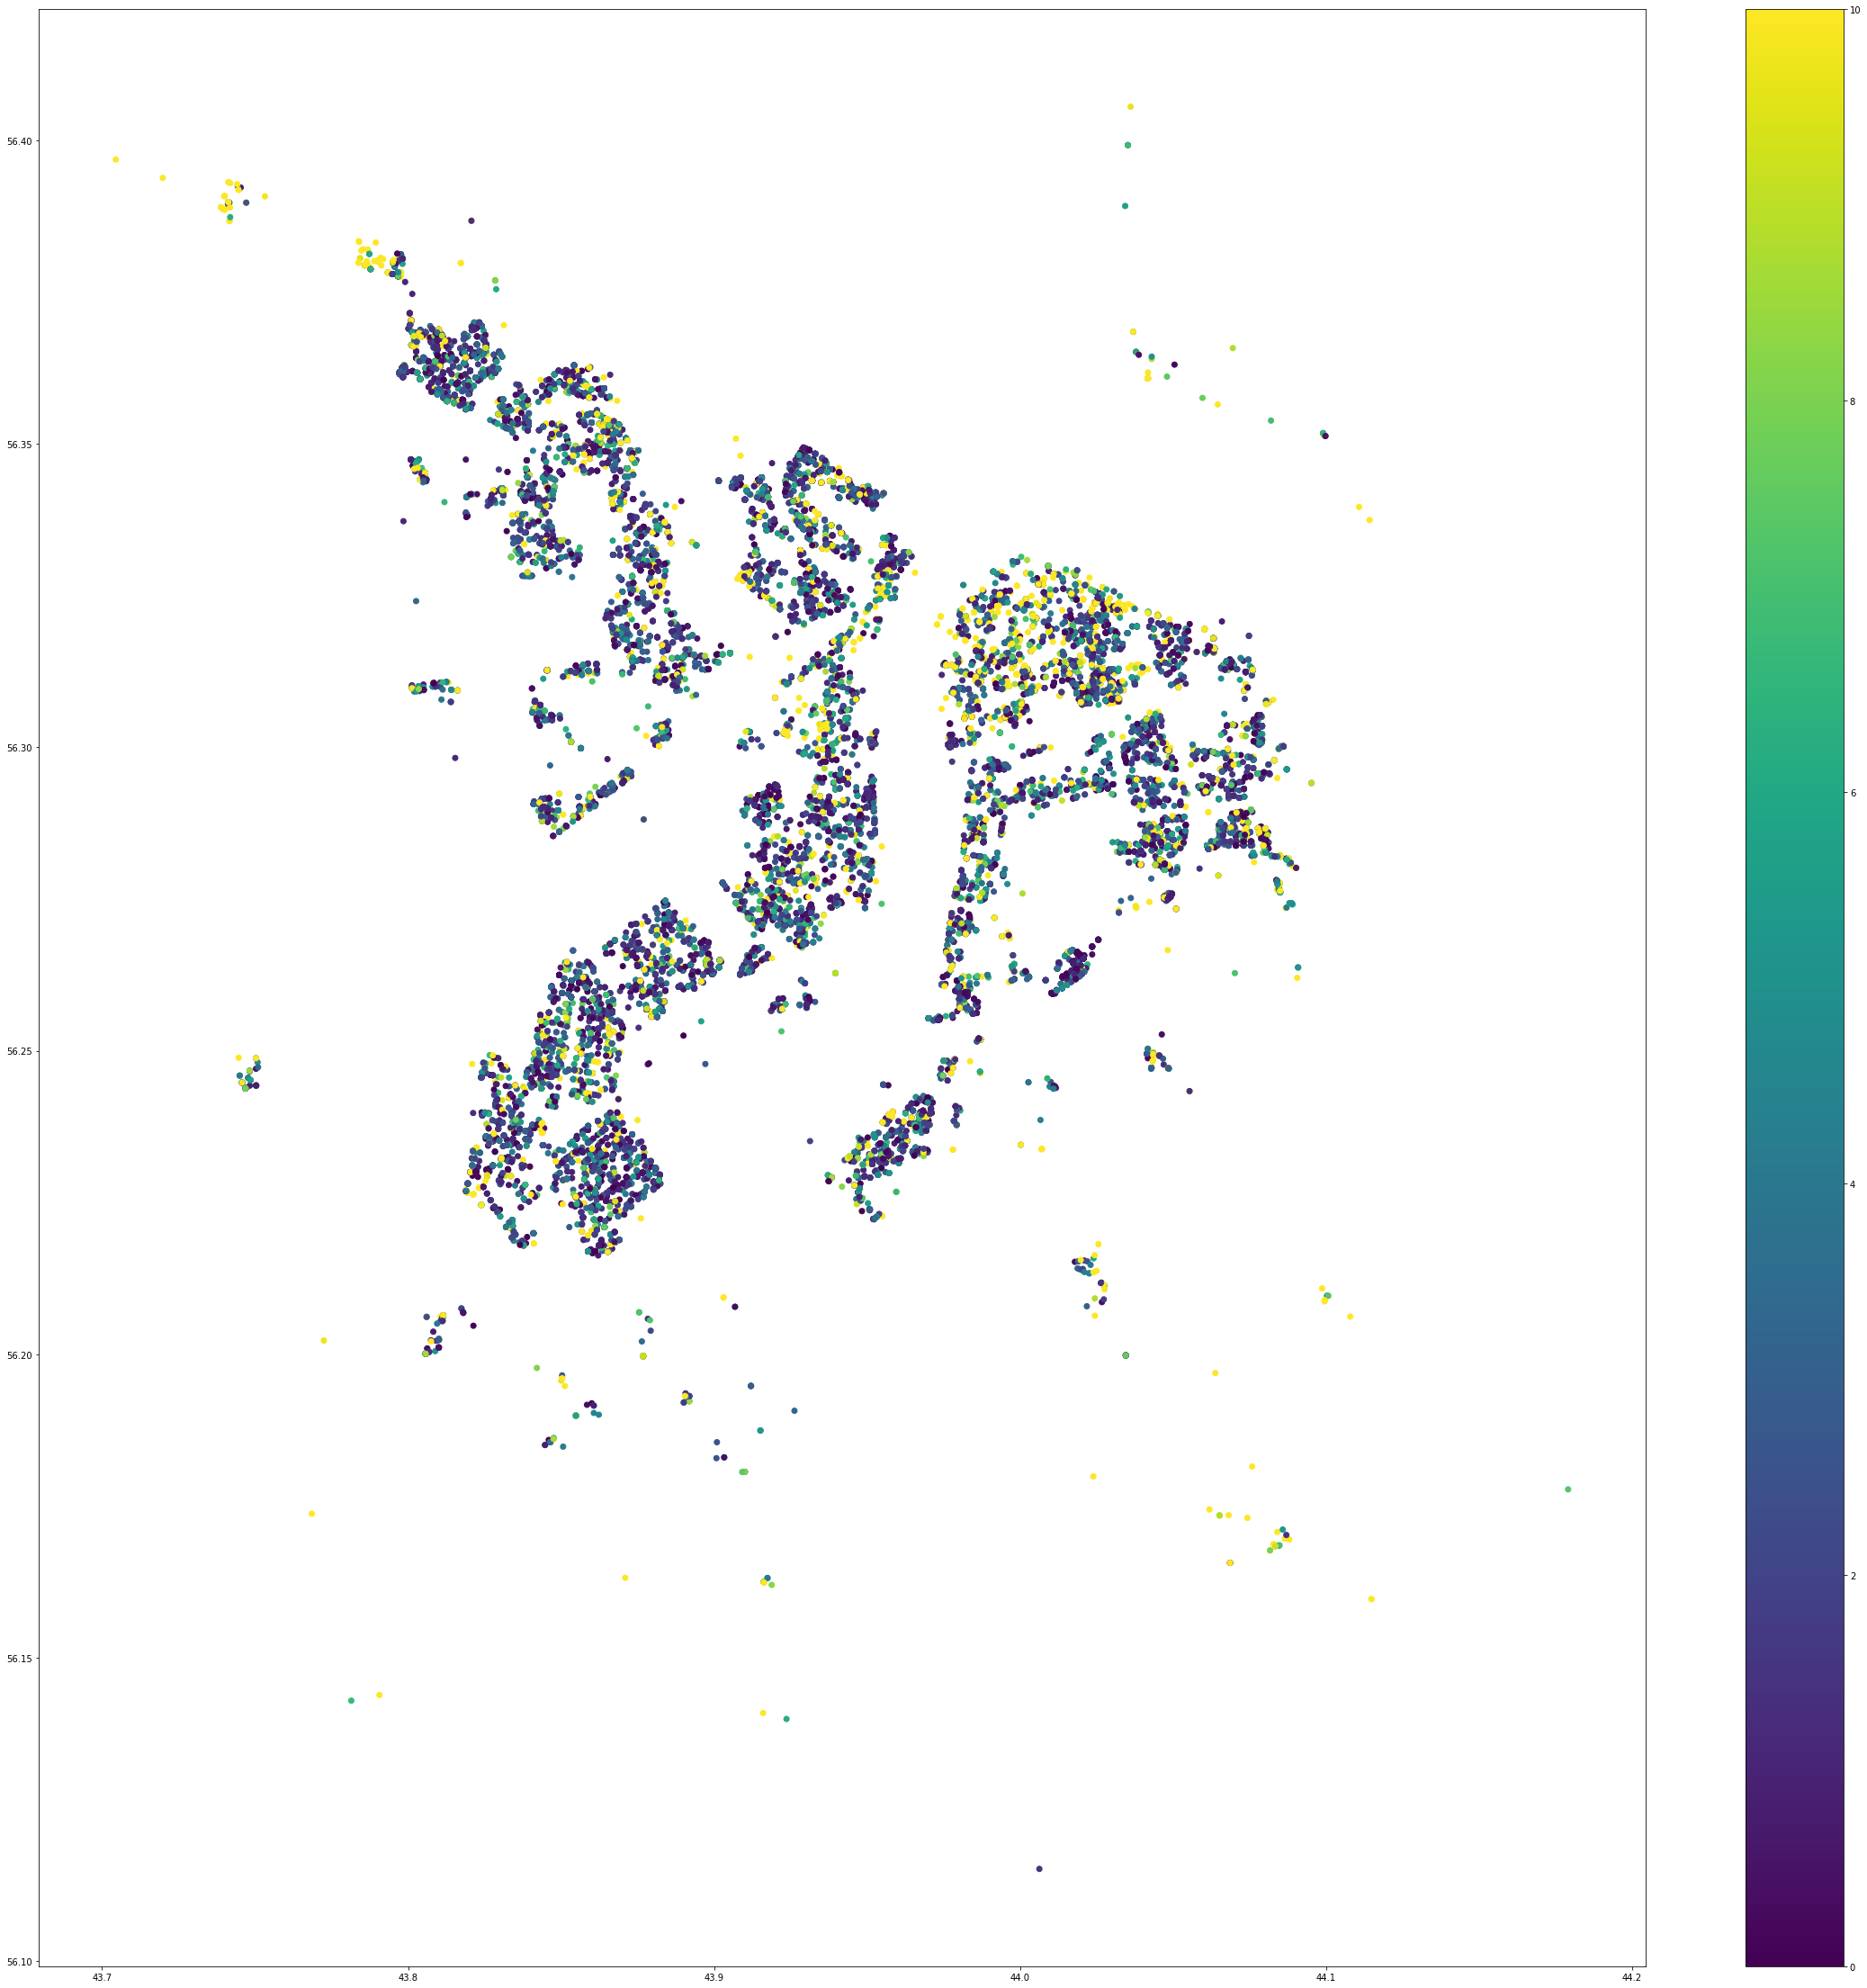

In [3]:
Y_predict = np.array( Y_predict )
Y_values  = np.array( Y_values  )

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
for threshold in [ 2.5, 5.0, 10.0 ]:
    bad_s  = np.sum( ( Y_relErr  > threshold ).astype( np.int ) )
    good_s = np.sum( ( Y_relErr <= threshold ).astype( np.int ) )
    print("threshold = {:5}, good = {:10}, bad = {:10}, err = {:4}".format( threshold, good_s, bad_s, bad_s/(good_s+bad_s)) )
x =  X_values[:,0]; y = X_values[:,1]; c = np.minimum(  Y_relErr, 10 );

plt.figure(figsize=(40,40))

plt.scatter (x, y, c=c  )
plt.colorbar()
plt.show    ()

In [4]:
from commonModel import MAX_LONGITUDE, MIN_LONGITUDE, MAX_LATITUDE, MIN_LATITUDE

import warnings
warnings.filterwarnings('ignore')

topK = 10

eps_x = ( MAX_LONGITUDE - MIN_LONGITUDE )*0.001
eps_y = ( MAX_LATITUDE  - MIN_LATITUDE  )*0.001
eps   = min( eps_x, eps_y )

topRelErrIndices = Y_relErr.argsort()[-topK:][::-1]
for i in topRelErrIndices :
    base_row = allDataFrame.iloc[ i ]
    base_x = base_row.longitude 
    base_y = base_row.latitude  
    print("BASE record")
    print( base_row )
    
    for index, cand_row in allDataFrame.iterrows():
        cand_x = cand_row.longitude
        cand_y = cand_row.latitude
        
        distance = np.sqrt( (cand_x-base_x)*(cand_x-base_x) + (cand_y-base_y)*(cand_y-base_y) )
        if distance < eps :
            print("CLOSEST record")
            print( cand_row )
    print("")
    

BASE record
type                Вторичка
price                 650000
longitude            43.9187
latitude             56.2566
total_square            21.5
living_square             12
kitchen_square             7
number_of_rooms            2
floor_number               9
number_of_floors           9
building_type               
Name: 39161, dtype: object
CLOSEST record
type                 Вторичка
price                 2.7e+06
longitude             43.9187
latitude              56.2566
total_square               62
living_square              54
kitchen_square              8
number_of_rooms             3
floor_number                2
number_of_floors            9
building_type       Панельный
Name: 1870, dtype: object
CLOSEST record
type                Вторичка
price               2.89e+06
longitude            43.9187
latitude             56.2566
total_square            50.2
living_square             39
kitchen_square             9
number_of_rooms            2
floor_number            


BASE record
type                 Вторичка
price                2.45e+06
longitude             43.9162
latitude              56.1625
total_square               90
living_square              52
kitchen_square             12
number_of_rooms             3
floor_number                4
number_of_floors            6
building_type       Кирпичный
Name: 24053, dtype: object
CLOSEST record
type                 Вторичка
price                   3e+06
longitude             43.9163
latitude              56.1624
total_square               90
living_square              53
kitchen_square             12
number_of_rooms             3
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 8908, dtype: object
CLOSEST record
type                 Вторичка
price                2.45e+06
longitude             43.9162
latitude              56.1625
total_square               90
living_square              52
kitchen_square             12
number_of_rooms             3
floo

CLOSEST record
type                Вторичка
price                2.5e+06
longitude             44.006
latitude             56.3269
total_square              43
living_square             28
kitchen_square             6
number_of_rooms            2
floor_number               5
number_of_floors           5
building_type               
Name: 6434, dtype: object
CLOSEST record
type                Вторичка
price               2.36e+06
longitude             44.006
latitude             56.3269
total_square              45
living_square             28
kitchen_square             6
number_of_rooms            2
floor_number               4
number_of_floors           5
building_type               
Name: 6436, dtype: object
CLOSEST record
type                 Вторичка
price                 1.6e+06
longitude              44.006
latitude              56.3269
total_square             67.6
living_square              42
kitchen_square              9
number_of_rooms             3
floor_number             

CLOSEST record
type                 Вторичка
price               4.396e+06
longitude              44.006
latitude              56.3269
total_square               80
living_square            44.4
kitchen_square           14.5
number_of_rooms             3
floor_number                4
number_of_floors            9
building_type                
Name: 12625, dtype: object
CLOSEST record
type                Вторичка
price                3.6e+06
longitude             44.006
latitude             56.3269
total_square              53
living_square             29
kitchen_square           8.5
number_of_rooms            2
floor_number               3
number_of_floors          14
building_type               
Name: 12680, dtype: object
CLOSEST record
type                Вторичка
price               2.95e+06
longitude             44.006
latitude             56.3269
total_square            44.6
living_square             26
kitchen_square           8.6
number_of_rooms            2
floor_number        

CLOSEST record
type                Вторичка
price               3.95e+06
longitude             44.006
latitude             56.3269
total_square              61
living_square             32
kitchen_square             9
number_of_rooms            2
floor_number              12
number_of_floors          12
building_type               
Name: 21549, dtype: object
CLOSEST record
type                Вторичка
price               1.51e+06
longitude             44.006
latitude             56.3269
total_square            36.1
living_square           26.6
kitchen_square             5
number_of_rooms            2
floor_number               4
number_of_floors           4
building_type               
Name: 21596, dtype: object
CLOSEST record
type                Вторичка
price               3.05e+06
longitude             44.006
latitude             56.3269
total_square            47.1
living_square           27.5
kitchen_square           8.2
number_of_rooms            2
floor_number               8
nu

CLOSEST record
type                 Вторичка
price                2.25e+06
longitude              44.006
latitude              56.3269
total_square             43.1
living_square            26.5
kitchen_square            5.6
number_of_rooms             2
floor_number                2
number_of_floors            5
building_type       Кирпичный
Name: 29537, dtype: object
CLOSEST record
type                 Вторичка
price               3.393e+06
longitude              44.006
latitude              56.3269
total_square             58.5
living_square            35.6
kitchen_square            9.5
number_of_rooms             2
floor_number                6
number_of_floors            9
building_type       Кирпичный
Name: 29540, dtype: object
CLOSEST record
type                Вторичка
price                3.1e+06
longitude             44.006
latitude             56.3269
total_square              60
living_square             35
kitchen_square            12
number_of_rooms            2
floor_num

CLOSEST record
type                 Вторичка
price                 1.7e+06
longitude              44.006
latitude              56.3269
total_square             52.2
living_square              28
kitchen_square            9.3
number_of_rooms             2
floor_number                3
number_of_floors            5
building_type       Панельный
Name: 44028, dtype: object
CLOSEST record
type                Вторичка
price                2.4e+06
longitude             44.006
latitude             56.3269
total_square              45
living_square             33
kitchen_square             5
number_of_rooms            2
floor_number               2
number_of_floors           5
building_type               
Name: 44853, dtype: object
CLOSEST record
type                 Вторичка
price                 4.8e+06
longitude              44.006
latitude              56.3269
total_square               68
living_square              35
kitchen_square           12.3
number_of_rooms             2
floor_number

CLOSEST record
type                 Вторичка
price                 2.8e+06
longitude              44.006
latitude              56.3269
total_square               42
living_square              28
kitchen_square              6
number_of_rooms             2
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 60226, dtype: object
CLOSEST record
type                 Вторичка
price                 3.7e+06
longitude              44.006
latitude              56.3269
total_square               54
living_square            34.4
kitchen_square            4.5
number_of_rooms             3
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 60305, dtype: object
CLOSEST record
type                 Вторичка
price                 2.8e+06
longitude              44.006
latitude              56.3269
total_square             46.1
living_square            27.9
kitchen_square              7
number_of_rooms             2
f

CLOSEST record
type                Вторичка
price                1.5e+06
longitude             44.006
latitude             56.3269
total_square            37.2
living_square             27
kitchen_square           5.7
number_of_rooms            2
floor_number               2
number_of_floors           3
building_type               
Name: 74474, dtype: object
CLOSEST record
type                 Вторичка
price                4.05e+06
longitude              44.006
latitude              56.3269
total_square               69
living_square              42
kitchen_square              9
number_of_rooms             3
floor_number                6
number_of_floors            9
building_type       Панельный
Name: 74593, dtype: object
CLOSEST record
type                 Вторичка
price                4.25e+06
longitude              44.006
latitude              56.3269
total_square               61
living_square            41.1
kitchen_square              6
number_of_rooms             4
floor_number

Name: 88854, dtype: object
CLOSEST record
type                 Вторичка
price                 3.4e+06
longitude              44.006
latitude              56.3269
total_square               66
living_square              42
kitchen_square              9
number_of_rooms             3
floor_number                6
number_of_floors            9
building_type       Кирпичный
Name: 88968, dtype: object
CLOSEST record
type                 Вторичка
price                 6.7e+06
longitude              44.006
latitude              56.3269
total_square               75
living_square              40
kitchen_square             15
number_of_rooms             2
floor_number                5
number_of_floors           10
building_type       Кирпичный
Name: 89033, dtype: object
CLOSEST record
type                 Вторичка
price                 2.9e+06
longitude              44.006
latitude              56.3269
total_square             48.4
living_square              29
kitchen_square              7
numb

CLOSEST record
type                 Вторичка
price                 2.4e+06
longitude              44.006
latitude              56.3269
total_square             48.2
living_square              32
kitchen_square              6
number_of_rooms             2
floor_number                2
number_of_floors            5
building_type       Панельный
Name: 102248, dtype: object
CLOSEST record
type                 Вторичка
price                4.22e+06
longitude              44.006
latitude              56.3269
total_square             52.7
living_square            30.3
kitchen_square              8
number_of_rooms             2
floor_number                4
number_of_floors            9
building_type       Кирпичный
Name: 103138, dtype: object
CLOSEST record
type                 Вторичка
price                 7.8e+06
longitude              44.006
latitude              56.3269
total_square              100
living_square              50
kitchen_square             15
number_of_rooms             3

CLOSEST record
type                Вторичка
price                  4e+06
longitude             44.006
latitude             56.3269
total_square              71
living_square             36
kitchen_square          12.5
number_of_rooms            2
floor_number               9
number_of_floors          10
building_type               
Name: 4317, dtype: object
CLOSEST record
type                Вторичка
price                2.7e+06
longitude             44.006
latitude             56.3269
total_square              46
living_square             31
kitchen_square             6
number_of_rooms            2
floor_number               5
number_of_floors           5
building_type               
Name: 4961, dtype: object
CLOSEST record
type                Вторичка
price                5.4e+06
longitude             44.006
latitude             56.3269
total_square             110
living_square           65.7
kitchen_square           7.7
number_of_rooms            5
floor_number               3
numb

type                 Вторичка
price                3.25e+06
longitude              44.006
latitude              56.3269
total_square               80
living_square              46
kitchen_square             10
number_of_rooms             3
floor_number                8
number_of_floors            9
building_type       Панельный
Name: 11659, dtype: object
CLOSEST record
type                 Вторичка
price                 2.6e+06
longitude              44.006
latitude              56.3269
total_square               41
living_square              27
kitchen_square             14
number_of_rooms             2
floor_number                3
number_of_floors            9
building_type       Кирпичный
Name: 11660, dtype: object
CLOSEST record
type                 Вторичка
price                2.35e+06
longitude              44.006
latitude              56.3269
total_square             38.1
living_square              24
kitchen_square            5.2
number_of_rooms             2
floor_number    

CLOSEST record
type                Вторичка
price               3.05e+06
longitude             44.006
latitude             56.3269
total_square            47.1
living_square           27.5
kitchen_square           8.2
number_of_rooms            2
floor_number               8
number_of_floors           9
building_type               
Name: 22467, dtype: object
CLOSEST record
type                Вторичка
price               3.15e+06
longitude             44.006
latitude             56.3269
total_square            58.3
living_square           38.4
kitchen_square           8.8
number_of_rooms            3
floor_number               7
number_of_floors           9
building_type               
Name: 22544, dtype: object
CLOSEST record
type                Вторичка
price                3.5e+06
longitude             44.006
latitude             56.3269
total_square            60.5
living_square           44.3
kitchen_square             7
number_of_rooms            3
floor_number               6
nu

CLOSEST record
type                Вторичка
price                3.8e+06
longitude             44.006
latitude             56.3269
total_square              63
living_square             47
kitchen_square             9
number_of_rooms            3
floor_number               9
number_of_floors           9
building_type               
Name: 38515, dtype: object
CLOSEST record
type                Вторичка
price                2.7e+06
longitude             44.006
latitude             56.3269
total_square              44
living_square           32.8
kitchen_square           5.5
number_of_rooms            2
floor_number               5
number_of_floors           5
building_type               
Name: 39567, dtype: object
CLOSEST record
type                 Вторичка
price                 4.2e+06
longitude              44.006
latitude              56.3269
total_square             62.5
living_square              38
kitchen_square            9.2
number_of_rooms             3
floor_number           

type                Новостройка
price                  2.89e+06
longitude                44.006
latitude                56.3269
total_square                 50
living_square                24
kitchen_square               10
number_of_rooms               2
floor_number                 10
number_of_floors             17
building_type                  
Name: 50587, dtype: object
CLOSEST record
type                Вторичка
price               3.15e+06
longitude             44.006
latitude             56.3269
total_square            61.5
living_square             48
kitchen_square           6.5
number_of_rooms            3
floor_number               4
number_of_floors           5
building_type               
Name: 53144, dtype: object
CLOSEST record
type                Вторичка
price                2.5e+06
longitude             44.006
latitude             56.3269
total_square              67
living_square             49
kitchen_square             5
number_of_rooms            3
floor_number 

CLOSEST record
type                 Вторичка
price                3.15e+06
longitude              44.006
latitude              56.3269
total_square             49.9
living_square            29.8
kitchen_square            8.7
number_of_rooms             2
floor_number                5
number_of_floors           10
building_type       Панельный
Name: 67482, dtype: object
CLOSEST record
type                 Вторичка
price                1.85e+06
longitude              44.006
latitude              56.3269
total_square               45
living_square              30
kitchen_square              7
number_of_rooms             2
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 67494, dtype: object
CLOSEST record
type                Вторичка
price                3.6e+06
longitude             44.006
latitude             56.3269
total_square              65
living_square             40
kitchen_square             8
number_of_rooms            3
floor_num

Name: 86845, dtype: object
CLOSEST record
type                 Вторичка
price                3.12e+06
longitude              44.006
latitude              56.3269
total_square             63.9
living_square            38.6
kitchen_square            9.4
number_of_rooms             3
floor_number                3
number_of_floors            9
building_type       Панельный
Name: 86847, dtype: object
CLOSEST record
type                 Вторичка
price                2.49e+06
longitude              44.006
latitude              56.3269
total_square             43.2
living_square            27.3
kitchen_square              7
number_of_rooms             2
floor_number                9
number_of_floors            9
building_type       Панельный
Name: 86852, dtype: object
CLOSEST record
type                 Вторичка
price                4.33e+06
longitude              44.006
latitude              56.3269
total_square               90
living_square              50
kitchen_square             16
numb

CLOSEST record
type                Вторичка
price                2.6e+06
longitude             44.006
latitude             56.3269
total_square              44
living_square           26.3
kitchen_square             6
number_of_rooms            2
floor_number               2
number_of_floors           5
building_type               
Name: 96284, dtype: object
CLOSEST record
type                Вторичка
price               3.15e+06
longitude             44.006
latitude             56.3269
total_square            62.2
living_square           42.6
kitchen_square             7
number_of_rooms            3
floor_number               2
number_of_floors           9
building_type               
Name: 96400, dtype: object
CLOSEST record
type                 Вторичка
price                 1.7e+06
longitude              44.006
latitude              56.3269
total_square               38
living_square              27
kitchen_square            5.5
number_of_rooms             2
floor_number           

CLOSEST record
type                 Вторичка
price                3.95e+06
longitude             44.0321
latitude              56.2732
total_square              120
living_square              86
kitchen_square             16
number_of_rooms             3
floor_number                5
number_of_floors            5
building_type       Кирпичный
Name: 4172, dtype: object
CLOSEST record
type                Новостройка
price                   3.6e+06
longitude               44.0323
latitude                56.2728
total_square                 68
living_square                30
kitchen_square               18
number_of_rooms               3
floor_number                  2
number_of_floors             18
building_type        Монолитный
Name: 96901, dtype: object



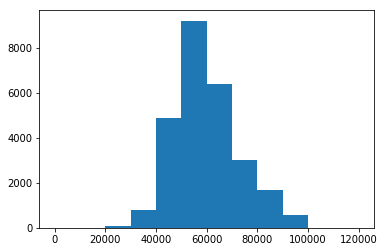

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

import matplotlib.pyplot as plt

bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000]

pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
pricePerSquareValues = pricePerSquare.values

plt.hist(  pricePerSquareValues, bins=bins )
plt.show()
